In [76]:
"""
Inpainting CMB example
"""

'\nInpainting CMB example\n'

In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
import numpy as np, sys, os, scipy as sc
sys.path.append('../')
import flatsky, tools, inpaint

#%pylab notebook
%matplotlib inline
from pylab import *
cmap = cm.RdYlBu

In [79]:
rcParams['figure.dpi'] = 150

In [114]:
#params or supply a params file
dx = 3.0 #arcmins
boxsize_am = 200. #boxsize in arcmins
nx = int(boxsize_am/dx)
mapparams = [nx, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx
verbose = 0
#lmax = 10000
#el = np.arange(lmax)

#for inpainting
low_pass_cutoff = False
maxel_for_grad_filter = 3000
use_cons_gau_sims = False ##True

#beam and noise levels
noiseval = 1.0 #uK-arcmin
beamval = 3. #arcmins

#CMB power spectrum
Cls_file = '../data/output_planck_r_0.0_2015_cosmo_lensedCls.dat'
Tcmb = 2.73

#for inpainting
noofsims = 1000
mask_radius_inner = 10.0 #arcmins
mask_radius_outer = 60.0 #arcmins
mask_inner = 0  #If 1, the inner region is masked before the LPF. Might be useful in the presence of bright SZ signal at the centre.

In [115]:
#get ra, dec or map-pixel grid
ra = np.linspace(x1,x2, nx) #arcmins
dec = np.linspace(x1,x2, nx) #arcmins
ra_grid, dec_grid = np.meshgrid(ra,dec)

In [116]:
#read Cls now
el, dl_tt, dl_ee, dl_bb, dl_te  = np.loadtxt(Cls_file, unpack = 1)
dl_all = np.asarray( [dl_tt, dl_ee, dl_bb, dl_te] )
dl_fac = el * (el + 1) / 2 / np.pi
cl_all = ( Tcmb**2. * dl_all ) / ( dl_fac )
cl_all = cl_all * 1e12
cl_tt, cl_ee, cl_bb, cl_te = cl_all #Cls in uK
cl = cl_tt
cl_dic = {}
cl_dic['TT'] = cl_tt

#loglog(el, cl_tt)
print(len(el))

19963


In [117]:
#get beam and noise
bl = tools.get_bl(beamval, el, make_2d = 1, mapparams = mapparams)
nl = tools.get_nl(noiseval, el)
nl_dic = {}
nl_dic['T'] = nl
print(nl_dic)

{'T': array([8.46159499e-08, 8.46159499e-08, 8.46159499e-08, ...,
       8.46159499e-08, 8.46159499e-08, 8.46159499e-08])}


Text(0.5, 0, 'Multipole $\\ell$')

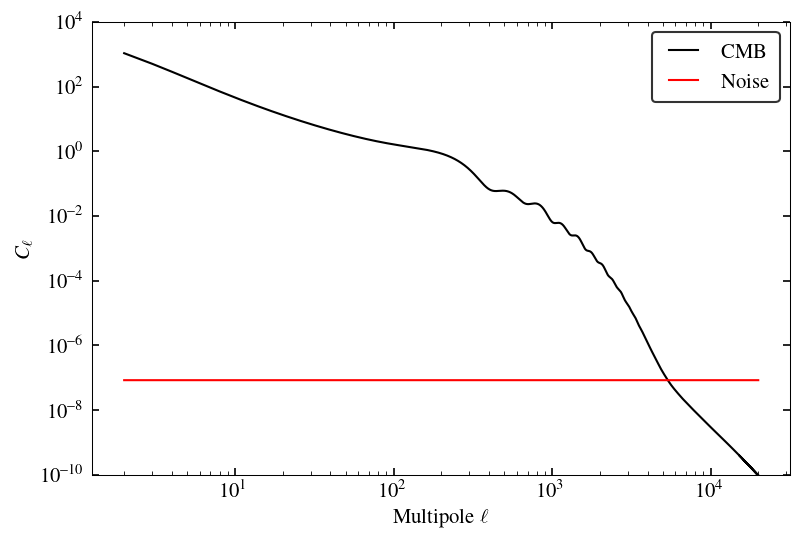

In [118]:
#plot
ax =subplot(111, yscale = 'log', xscale = 'log')
plot(el, cl_tt, 'k-', label = r'CMB')
plot(el, nl, 'r-', label = r'Noise')
legend(loc = 1)
ylim(1e-10, 1e4)
ylabel(r'$C_{\ell}$')
xlabel(r'Multipole $\ell$')

In [119]:
#get covariance for inpainting
sigma_dic = inpaint.get_covariance(ra_grid, dec_grid, mapparams, el, cl_dic, bl, nl_dic, noofsims, mask_radius_inner, mask_radius_outer, low_pass_cutoff = low_pass_cutoff, maxel_for_grad_filter = maxel_for_grad_filter)
print(sigma_dic.keys())


	calculating the covariance from simulations for inpainting

		generating 1000 sims

			invert sigma_22 matrix (1192,1192) now

		covariance obtained
dict_keys(['sigma_22_inv', 'sigma_12'])


/Users/sraghunathan/Research/SPTpol/analysis/git/inpainting/work/../flatsky.py:238: RuntimeWarning: divide by zero encountered in true_divide
  errval=std_mean/(hit_count)**0.5


Text(0.5, 0, 'Multipole $\\ell$')

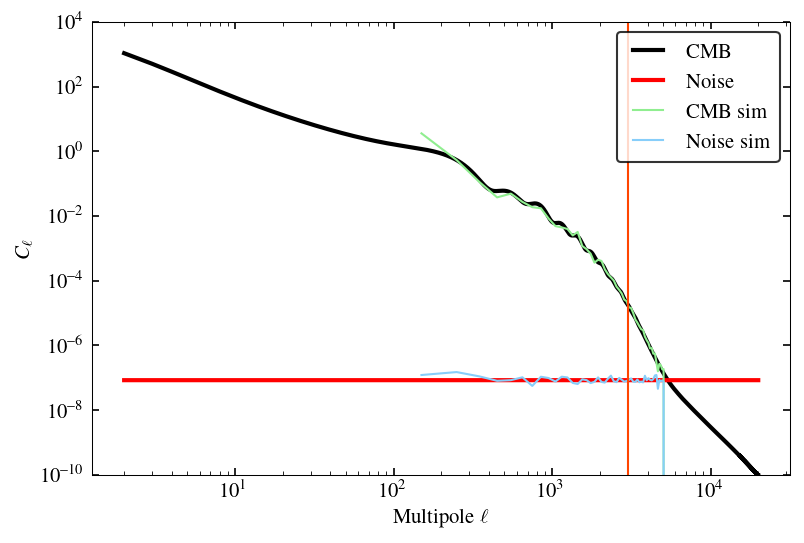

In [120]:
#create CMB and convolve with beam
cmb_map = flatsky.make_gaussian_realisation(mapparams, el, cl, bl = bl)

#noise map
noise_map = flatsky.make_gaussian_realisation(mapparams, el, nl)
sim_map = cmb_map + noise_map
subplot(131);imshow(cmb_map, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'CMB')
subplot(132);imshow(noise_map, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Noise')
subplot(133);imshow(sim_map, extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'CMB + Noise')

#get sim power
minbin, maxbin, delta_l = 100, 15000, 100
el_, cl_cmb_sim = flatsky.map2cl(mapparams, cmb_map, binsize = delta_l, minbin = minbin, maxbin = maxbin)
bl_ = tools.get_bl(beamval, el_, make_2d = 0)
cl_cmb_sim = cl_cmb_sim / bl_**2.

el_, cl_noise_sim = flatsky.map2cl(mapparams, noise_map, binsize = delta_l, minbin = minbin, maxbin = maxbin)

#Check the power in sims

#plot
clf()

#theory
ax =subplot(111, yscale = 'log', xscale = 'log')
plot(el, cl_tt, 'k-', lw = 2., label = r'CMB')
plot(el, nl, 'r-', lw = 2., label = r'Noise')

#sims
plot(el_, cl_cmb_sim, 'k-', color = 'lightgreen', lw = 1., label = r'CMB sim')
plot(el_, cl_noise_sim, 'r-', color = 'lightskyblue', lw = 1., label = r'Noise sim')
if (1):##low_pass_cutoff:
    axvline(maxel_for_grad_filter, color = 'orangered')

legend(loc = 1)
ylim(1e-10, 1e4)
ylabel(r'$C_{\ell}$')
xlabel(r'Multipole $\ell$')

In [121]:
#perform inpainting
sim_map_dic = {}
sim_map_dic['T'] = sim_map
print(sim_map_dic.keys())
cmb_inpainted_map, sim_map_inpainted, sim_map_filtered = inpaint.inpainting(sim_map_dic, ra_grid, dec_grid, mapparams, el, cl_dic, bl, nl_dic, noofsims, mask_radius_inner, mask_radius_outer, low_pass_cutoff = low_pass_cutoff, mask_inner = mask_inner, sigma_dic = sigma_dic, maxel_for_grad_filter = maxel_for_grad_filter, use_cons_gau_sims = use_cons_gau_sims)


dict_keys(['T'])


In [122]:
use_cons_gau_sims

False

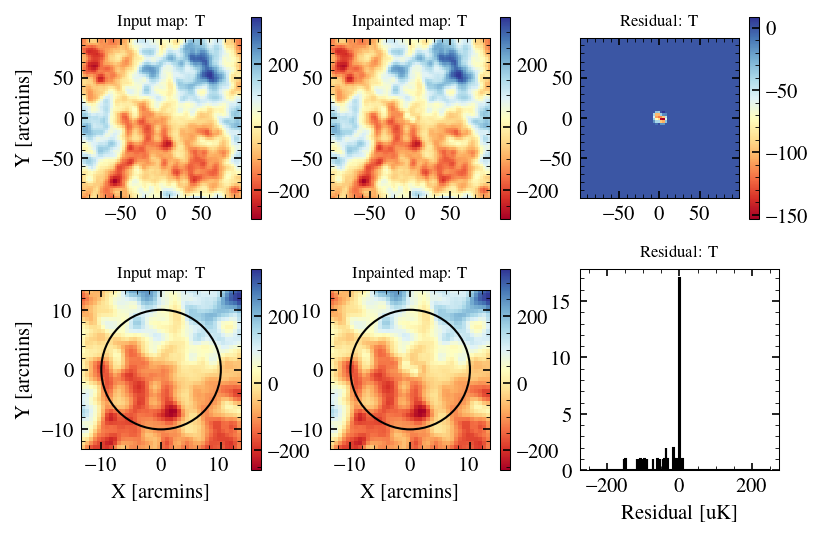

In [123]:
clf()
subplots_adjust(hspace = 0.25, wspace = 0.25)
tquarr = ['T', 'Q', 'U']
tqulen = len(cmb_inpainted_map)
tr, tc = 2, 3
sbpl = 1
fsval = 8
for tqucntr in range(0,1): #plot T first
    subplot(tr, tc, sbpl);imshow(sim_map_filtered[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Input map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    ylabel('Y [arcmins]')
    sbpl+=1
    subplot(tr, tc, sbpl);imshow(sim_map_inpainted[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Inpainted map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    residual = sim_map_filtered - sim_map_inpainted
    subplot(tr, tc, sbpl);imshow(residual[tqucntr], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Residual: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1

    #zooming in
    #s, e = 95, 105
    s = int(nx/2) - 20
    e = int(nx/2) + 20
    x1, x2 = -(e-s)/dx,(e-s)/dx
    circle = Circle((0, 0), radius = mask_radius_inner, facecolor='None', edgecolor = 'black', lw = 1., ls = '-');
    ax=subplot(tr, tc, sbpl);imshow(sim_map_filtered[tqucntr, s:e, s:e], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Input map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    ax.add_artist(circle)
    xlabel('X [arcmins]'); ylabel('Y [arcmins]')

    circle = Circle((0, 0), radius = mask_radius_inner, facecolor='None', edgecolor = 'black', lw = 1., ls = '-');
    ax=subplot(tr, tc, sbpl);imshow(sim_map_inpainted[tqucntr, s:e, s:e], extent = [x1,x2,x1,x2], cmap = cmap); colorbar(); title(r'Inpainted map: %s' %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    ax.add_artist(circle)
    xlabel('X [arcmins]')

    s = int(nx/2 - mask_radius_inner/dx)
    e = int(nx/2 + mask_radius_inner/dx)
    residual_flatten = (residual[0, s:e, s:e].flatten())
    
    minval, maxval, delta = -250., 250., 1.
    binbin = np.arange(minval, maxval, delta)
    subplot(tr, tc, sbpl);hist(residual_flatten, bins = binbin, histtype = 'step', color = 'black'); title(r'Residual: %s'  %(tquarr[tqucntr]), fontsize = fsval)
    sbpl+=1
    xlabel(r'Residual [uK]')

show()

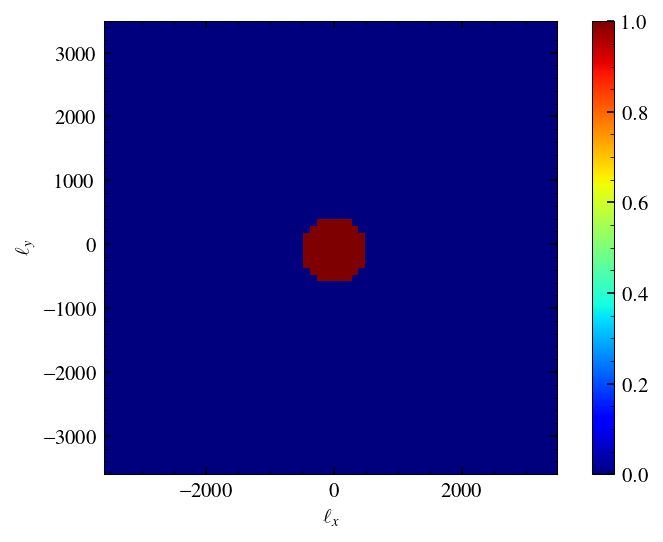

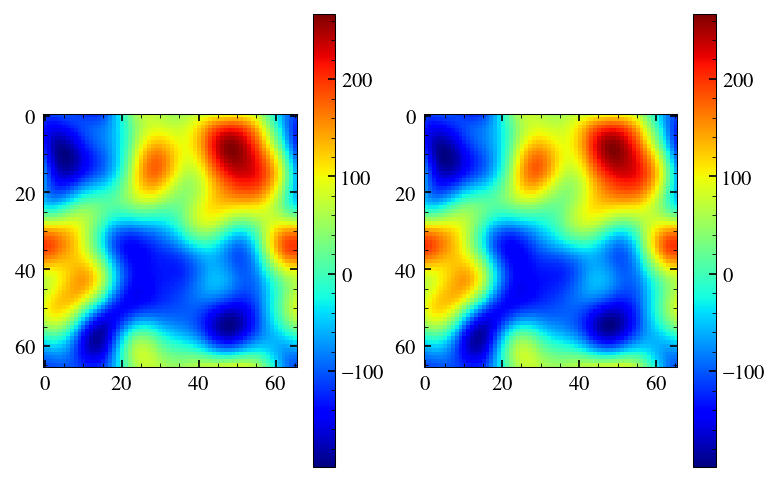

In [124]:
m1, m2 = np.copy( sim_map_filtered[0] ), np.copy( sim_map_inpainted[0] )
lx, ly = flatsky.get_lxly(mapparams)
ell = np.sqrt( lx**2 + ly**2 )
fft_filter = np.ones_like( ell )
fft_filter[ell>500.] = 0.
imshow( np.fft.fftshift(fft_filter), extent = [np.min(lx), np.max(lx), np.min(ly), np.max(ly)])
colorbar()
xlabel(r'$\ell_{x}$'); ylabel(r'$\ell_{y}$')
show()

m1, m2 = np.fft.ifft2( np.fft.fft2( m1 ) * fft_filter ).real, np.fft.ifft2( np.fft.fft2( m2 ) * fft_filter ).real
subplot(121); imshow(m1); colorbar()
subplot(122); imshow(m2); colorbar(); show()